# Juggling RL project

## Install dependencies

It is also necessary to have ffmpeg software installed, in particular its bin folder in your path : <br>

On Windows : tuto - https://www.wikihow.com/Install-FFmpeg-on-Windows <br>
download - https://www.gyan.dev/ffmpeg/builds/


In [9]:
#!pip install gymnasium
#!pip install keras-rl2
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces

## Import model

""

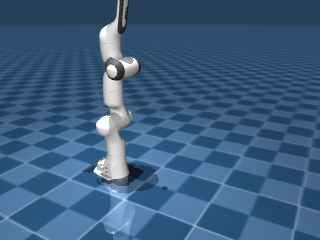

In [2]:
# Make model and data -- https://mujoco.readthedocs.io/en/stable/python.html
model = mujoco.MjModel.from_xml_path("./robot/scene.xml") #
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [8]:
duration = 4  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.ctrl[1]=-0.476
data.ctrl[2]=-2.14
while data.time < duration: #data.time in second (float)
  if int(data.time*1000) % 1000 == 0: print(data.time)
  if int(data.time*1000) % 100 == 0: print(data.xpos[8])
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

0.0
[0. 0. 0.]
[0.33   0.     1.4902]
[0.33   0.     1.4604]
[0.33   0.     1.4106]
[0.33   0.     1.3408]
[0.33  0.    1.251]
[0.33   0.     1.1412]
[0.33   0.     1.0114]
[0.33   0.     0.8616]
[ 0.3264302  -0.00176189  0.73515021]
1.0000000000000007
[ 0.32315254 -0.00160468  0.73753356]
[ 0.32277896 -0.00189816  0.73911723]
[ 0.32277861 -0.00227607  0.74035703]
[ 0.32286545 -0.00266221  0.74151209]
[ 0.32296404 -0.00291441  0.74255997]
[ 0.32306607 -0.00308702  0.74352258]
[ 0.32331723 -0.00320494  0.74439259]
[ 0.32367678 -0.00325719  0.74509458]
[ 0.3239472  -0.00328051  0.7455807 ]
[ 0.32413445 -0.00329683  0.7459023 ]
2.0000000000000013
[ 0.32426047 -0.00330385  0.74611403]


## Monte Carlo method

Possible improvements :
 - Many high policies
 - Add the old best policy to the new list of roll_outs policies to have an increasing reward
 - Stop a roll_out when the ball hits the ground or do not cross the threshold for 4 sec (e.g.)

In [13]:
# inspect allows you to get all the method of a class 
# - useful to understand a library with little documentation
# import inspect
# inspect.getmembers(data, predicate=inspect.ismethod)

# We found out that the position are given among others by data.xpos
# It is a list of list for each body with x, y and z position
# Position of the ball in our model : data.xpos[-1] = data.xpos[8]
# It is probably because we loaded the ball after the juggler in scene.xml

In [3]:
# Format of a trajectory (dur_cycle, ((t1, x1, y1, z1), ..., (tn, xn, yn, zn)))
# Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
# command[0] = 0 if not a cycle
# command[0] > 0 if it is a cycle (then dur_cycle > tn)

expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                 [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                 [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]

def trajectory_to_command(trajectory): # Error if out of range
    pass

def update_arm(command, current_time, command_step):
    #print(round(current_time, 3))
    if ((int(round(current_time * 500))*2) % (int(round(command[0]*500))*2) == 
        int(round(command[1][command_step][0]*500))*2):
        # print(((int(round(current_time * 500))*2) % (int(round(command[0]*500))*2) == 
        # int(round(command[1][command_step][0]*500))*2))
        data.ctrl[1] = command[1][command_step][1]
        data.ctrl[2] = command[1][command_step][2]
        # print(command_step)
        # print(int(round(current_time * 500))*2)
        # print(int(round(command[1][command_step][0]*500))*2)
        # print("duration", int(round(command[0]*500))*2)
        # print("=====")
        command_step = (command_step + 1) % len(command[1])
    #print("in function", command_step)
    return command_step

In [45]:
# Simulate and display video.
def simulation_video(command):
  frames = []
  ball_positions = []
  mujoco.mj_resetData(model, data)  # Reset state and time.
  command_step = 0
  while data.time < duration: #data.time in second (float)
    #if abs(round(data.time) - data.time) < 0.005: print(data.time)
    if int(round(data.time * 1000)) % 10000 == 0: print(f"Computed {int(round(data.time))} out of {duration} seconds")
    if int(round(data.time * 1000)) % 10 == 0: ball_positions.append(data.xpos[-1].copy())
    command_step = update_arm(command, data.time, command_step)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render().copy()
      frames.append(pixels)
    #print(command_step)
  return frames, ball_positions

In [5]:
expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]

In [123]:
command_old = (4, ((0, -0.476, -2.14), (1, -0.3, -1.9), (2, -0.1, -1.8),
               (3, 0.2, -1.5)))

duration = 120  # (seconds)
framerate = 10  # (Hz)
video, ball_positions = simulation_video(expert_command)
media.show_video(video, fps=framerate)

Computed 0 out of 120 seconds
Computed 10 out of 120 seconds
Computed 20 out of 120 seconds
Computed 30 out of 120 seconds
Computed 40 out of 120 seconds
Computed 50 out of 120 seconds
Computed 60 out of 120 seconds
Computed 70 out of 120 seconds
Computed 80 out of 120 seconds
Computed 90 out of 120 seconds
Computed 100 out of 120 seconds
Computed 110 out of 120 seconds
Computed 120 out of 120 seconds


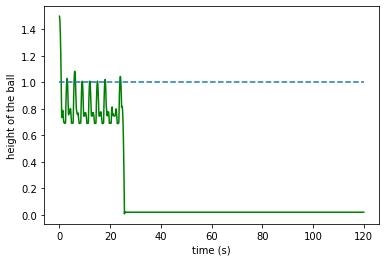

In [125]:
fig, axs = plt.subplots()
axs.plot([0.010*i for i in range(1, len(ball_positions))],
        [ball_position[2] for ball_position in ball_positions[1:]], "g")
axs.set_xlabel("time (s)")
axs.set_ylabel("height of the ball")
axs.hlines(y=1, linestyles='dashed', xmin=0, xmax=0.010*len(ball_positions))

In [13]:
len(video)

101

In [65]:
# Global Variables

PROBA_DUPLICATED = 0.1 #Not used for the moment
PROBA_REMOVED = 0.1 #Not used for the moment
CYCLE_DURATION_SD = 0.05 #second
MAX_CYCLE_DURATION = 5

TIME_SD = 0.02 #second
ACT2_SD = 0.01 #radiant
ACT3_SD = 0.01 #radiant

THRESHOLD = 1 #meter

FRAMERATE = 10 
DURATION = 120

In [80]:
class Monte_Carlo_method():
    def __init__(self, proba_duplicated, proba_removed, cycle_duration_sd, 
                max_cycle_duration, time_sd, act2_sd, act3_sd, threshold, 
                framerate, duration, high_policy_computation="greedy",
                keep_videos=False, verbose=False):
        self.proba_duplicated = proba_duplicated
        self.proba_removed = proba_removed
        self.cycle_duration_sd = cycle_duration_sd
        self.max_cycle_duration = max_cycle_duration
        
        self.time_sd = time_sd
        self.act2_sd = act2_sd
        self.act3_sd = act3_sd
        self.threshold = threshold
        self.framerate = framerate
        self.duration = duration

        self.high_policy_computation = high_policy_computation
        self.keep_videos = keep_videos
        self.verbose = verbose
        self.videos = []


    def learning(self, expert_command, nb_episodes=5, nb_roll_outs=20): 
        """
        Description : Global function with the loop over episodes
        Input :
        - Look above
        Output :
        - The last high policy
        - The best policy of each episode
        """
        high_policy = expert_command

        best_results = [[high_policy, self.reward(self.roll_out(high_policy))]]

        if self.verbose: print("Start learning")
        for id_episode in range(nb_episodes):
            if self.verbose: print(f"Episode {id_episode + 1} / {nb_episodes} |", end="")
            results, best_result = self.episode(high_policy, nb_roll_outs, best_results[-1])
            if self.verbose: print(f" | best reward : {best_result[1]}", end="\n")
            best_results.append(best_result)
            high_policy = self.compute_high_policy(results, best_result)
            # print(" Debug :", end="\n")
            # print(results)
            # print(high_policy)

        return high_policy, best_results
            

    def episode(self, high_policy, nb_roll_outs, last_best_result): 
        """
        Loop over roll_outs
        Output:
        - All the commands of the roll-outs with associated rewards
        - The best command of the episode with associated reward
        """
        best_result = last_best_result
        results = [last_best_result]
        for id_roll_out in range(nb_roll_outs):
            if self.verbose: print(">", end="")
            command = self.sample_policy(high_policy)
            ball_positions = self.roll_out(command)
            roll_out_reward = self.reward(ball_positions)
            if roll_out_reward>best_result[1]:
                best_result = [command, roll_out_reward]
            results.append([command, roll_out_reward])
        return results, best_result


    def roll_out(self, command): 
        """
        Get a deterministic policy from the stochastic policy of the episode
        Input:
        - A command
        Output:
        - The ball positions at each steps
        """
        ball_positions = self.simulation_roll_out(command)
        #print(command)
        return ball_positions

    def reward(self, ball_pos_list): 
        """
        From the list of the ball positions returned by a roll_out, returns the reward
        """
        count_juggling = 1 #Be careful for division_by_zero problem, the reward is one more than the number of time the ball crosses the threshold while going up.
        below_before = False
        #time_count = 0
        for ball_pos in ball_pos_list[1:]: #Be careful, the ball is at 0, 0, 0 at the beginning
            if below_before and ball_pos[2] > self.threshold:
                count_juggling += 1
                #print(time_count, ball_pos[2], count_juggling)
                below_before = False
            if (not below_before) and ball_pos[2] < self.threshold:
                below_before = True
            #time_count += 0.002
        
        return count_juggling


    def compute_high_policy(self, results, best_result): 
        # For the moment the length of a command is a hyperparameter
        """
        Merge the roll_out policies using a weighted sum depending 
        on the number of catches (in episode != 0)
        Input:
        - 
        """
        if self.high_policy_computation == "greedy":
            high_policy = best_result[0]

        elif self.high_policy_computation == "mean":
            nb_step = len(results[0][0][1])
            high_policy = [0, [[0, 0, 0] for i in range(nb_step)]]
            sum_reward = 0
            for result in results: # result = [command, reward]
                sum_reward += result[1]
                high_policy[0] += result[0][0] * result[1]
                for step in range(nb_step):
                    high_policy[1][step][0] += result[0][1][step][0] * result[1]
                    high_policy[1][step][1] += result[0][1][step][1] * result[1]
                    high_policy[1][step][2] += result[0][1][step][2] * result[1]
            #normalisation
            for step in range(nb_step):
                high_policy[0] /= sum_reward
                high_policy[1][step][0] /= sum_reward
                high_policy[1][step][1] /= sum_reward
                high_policy[1][step][2] /= sum_reward

        return high_policy


    def sample_policy(self, high_policy):
        # Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
        """
        Sampling of a command = low_policy from the high_policy
        - A command step may be duplicated (not implemented yet)
        - A command step may be removed (not implemented yet)
        - The cycle duration is sampled
        - Each coordinate of the command steps are sampled 
        """
        nb_steps_high_policy = len(high_policy[1])
        command = [0, []]
        duplicated = [0]*nb_steps_high_policy
        removed = [0]*nb_steps_high_policy
        #duplicated = [np.random.Generator.binomial(1, self.proba_duplicated) for i in range(nb_steps_high_policy)]
        #removed = [np.random.Generator.binomial(1, self.proba_removed) for i in range(nb_steps_high_policy)]
        cycle_duration = np.clip(np.random.normal(loc=high_policy[0],scale=self.cycle_duration_sd), 0, self.max_cycle_duration)

        command[0] = cycle_duration
        for id_step in range(nb_steps_high_policy):
            if not removed[id_step]:
                time_previous = -0.05
                for i in range(duplicated[id_step] + 1):
                    step_time = np.clip(
                            np.random.normal(loc=high_policy[1][id_step][0], 
                                             scale=self.time_sd),
                            time_previous+0.05, cycle_duration)
                    time_previous = step_time #saw a problem with it 
                    step_act2 = np.clip(
                            np.random.normal(loc=high_policy[1][id_step][1], 
                                             scale=self.act2_sd),
                            model.actuator_ctrlrange[1][0], model.actuator_ctrlrange[1][1])
                    step_act3 = np.clip(
                            np.random.normal(loc=high_policy[1][id_step][2], 
                                             scale=self.act3_sd),
                            model.actuator_ctrlrange[2][0], model.actuator_ctrlrange[2][1])
                    command[1].append([step_time, step_act2, step_act3])

        return(command)


    def simulation_roll_out(self, command): 
        """
        Or modify the previous one
        """
        ball_positions = []
        if self.keep_videos: frames = []
        mujoco.mj_resetData(model, data)  # Reset state and time.
        command_step = 0
        while data.time < self.duration: #data.time in second (float)
            command_step = update_arm(command, data.time, command_step) #Warning : function outside of the class
            if int(round(data.time * 1000)) % 10 == 0: ball_positions.append(data.xpos[-1].copy())
            mujoco.mj_step(model, data)
            if self.keep_videos:
                if len(frames) < data.time * self.framerate:
                    if self.keep_videos: 
                        renderer.update_scene(data)
                        pixels = renderer.render().copy()
                        frames.append(pixels)
        if self.keep_videos: self.videos.append(frames)
        return ball_positions

In [99]:
def print_reward_evolution(results):
    nb_episode = len(results[1]) - 1
    id_episode = [i for i in range(nb_episode + 1)]
    ep_rewards = [results[1][i][1] - 1 for i in range(nb_episode + 1)] #minus one because the reward is the number of juggle + 1 (not to divide by zero...)
    fig, axs = plt.subplots()
    axs.plot(id_episode, ep_rewards, "g.")
    axs.set_xlabel("episodes")
    axs.set_ylabel("reward")
    axs.hlines(y=7, linestyles='dashed', xmin=0, xmax=nb_episode)
    axs.set_ybound(lower=0)

In [82]:
method = Monte_Carlo_method(PROBA_DUPLICATED, PROBA_REMOVED, CYCLE_DURATION_SD, 
                MAX_CYCLE_DURATION, TIME_SD, ACT2_SD, ACT3_SD, THRESHOLD, 
                FRAMERATE, DURATION, keep_videos=False, verbose=True)

In [83]:
expert_command = [3, [[0, -0.476, -2.14], [0.9, -0.38, -2.05], [1, -0.3, -1.95],
                [1.1, -0.2, -1.85], [1.2, -0.1, -1.78], [1.3, 0, -1.74], [1.5, 0.1, -1.68],
                [1.7, 0.15, -1.6], [2.4, 0.2, -1.18], [2.8, -0.476, -2.14]]]

In [114]:
results = method.learning(expert_command, nb_episodes=150, nb_roll_outs=8)
# results = method.learning(expert_command, nb_episodes=40, nb_roll_outs=40) with DURATION = 40 => 1h30 very good results 9 - 12 - 14
# PROBA_DUPLICATED = 0.1
# PROBA_REMOVED = 0.1
# CYCLE_DURATION_SD = 0.05 #second
# MAX_CYCLE_DURATION = 5
# TIME_SD = 0.02 #second
# ACT2_SD = 0.02 #radiant
# ACT3_SD = 0.02 #radiant
# THRESHOLD = 1 #meter
# FRAMERATE = 10 
# DURATION = 40

# results = method.learning(expert_command, nb_episodes=20, nb_roll_outs=40) with same hparam and DURATION = 120 => 24m 33 no good results

# results = method.learning(expert_command, nb_episodes=5, nb_roll_outs=20) with DURATION = 40 => 1h30 good results 9 - 13 - 21 problem with this 21
# PROBA_DUPLICATED = 0.1
# PROBA_REMOVED = 0.1
# CYCLE_DURATION_SD = 0.05 #second
# MAX_CYCLE_DURATION = 5
# TIME_SD = 0.02 #second
# ACT2_SD = 0.02 #radiant
# ACT3_SD = 0.02 #radiant
# THRESHOLD = 1 #meter
# FRAMERATE = 10 
# DURATION = 40

Start learning
Episode 1 / 150 |>>>>>>>> | best reward : 8
Episode 2 / 150 |>>>>>>>> | best reward : 8
Episode 3 / 150 |>>>>>>>> | best reward : 8
Episode 4 / 150 |>>>>>>>> | best reward : 8
Episode 5 / 150 |>>>>>>>> | best reward : 8
Episode 6 / 150 |>>>>>>>> | best reward : 9
Episode 7 / 150 |>>>>>>>> | best reward : 9
Episode 8 / 150 |>>>>>>>> | best reward : 9
Episode 9 / 150 |>>>>>>>> | best reward : 9
Episode 10 / 150 |>>>>>>>> | best reward : 9
Episode 11 / 150 |>>>>>>>> | best reward : 9
Episode 12 / 150 |>>>>>>>> | best reward : 9
Episode 13 / 150 |>>>>>>>> | best reward : 9
Episode 14 / 150 |>>>>>>>> | best reward : 9
Episode 15 / 150 |>>>>>>>> | best reward : 9
Episode 16 / 150 |>>>>>>>> | best reward : 9
Episode 17 / 150 |>>>>>>>> | best reward : 9
Episode 18 / 150 |>>>>>>>> | best reward : 9
Episode 19 / 150 |>>>>>>>> | best reward : 9
Episode 20 / 150 |>>>>>>>> | best reward : 9
Episode 21 / 150 |>>>>>>>> | best reward : 9
Episode 22 / 150 |>>>>>>>> | best reward : 14
Epi

In [115]:
print(results[1][-1][0])

[2.8459953544933274, [[0.0, -0.456477904976338, -2.1308407455662004], [0.9385533893335879, -0.39519303434180153, -2.052479450372485], [1.075109926992127, -0.2910108211664301, -1.9838428307143552], [1.0560965356836884, -0.2310281380276751, -1.9148728982814214], [1.1830580376428175, -0.13749205260502237, -1.804588505213239], [1.3536815436306635, 0.024886808738906446, -1.719918233791255], [1.4358471596825093, 0.10152911525938542, -1.6758227722980985], [1.663799096323436, 0.15026862758103687, -1.597858804857905], [2.408456701717146, 0.2003374320141382, -1.1911967544207618], [2.821330025365467, -0.4618009463192903, -2.1425239507556975]]]


In [122]:
#results

In [117]:
#media.show_video(method.videos[0], fps=FRAMERATE)

In [118]:
framerate = 10
duration = 120
video, ball_positions = simulation_video(results[1][-1][0])
media.show_video(video, fps=framerate)

Computed 0 out of 120 seconds
Computed 10 out of 120 seconds
Computed 20 out of 120 seconds
Computed 30 out of 120 seconds
Computed 40 out of 120 seconds
Computed 50 out of 120 seconds
Computed 60 out of 120 seconds
Computed 70 out of 120 seconds
Computed 80 out of 120 seconds
Computed 90 out of 120 seconds
Computed 100 out of 120 seconds
Computed 110 out of 120 seconds
Computed 120 out of 120 seconds


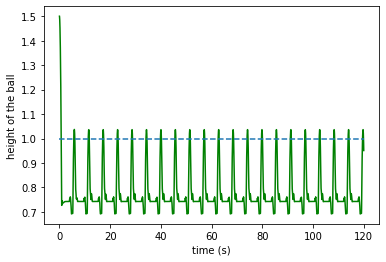

In [119]:
fig, axs = plt.subplots()
axs.plot([0.010*i for i in range(1, len(ball_positions))],
        [ball_position[2] for ball_position in ball_positions[1:]], "g")
axs.set_xlabel("time (s)")
axs.set_ylabel("height of the ball")
axs.hlines(y=1, linestyles='dashed', xmin=0, xmax=0.010*len(ball_positions))

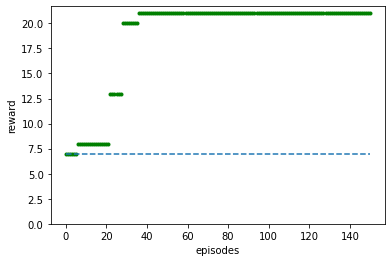

In [120]:
print_reward_evolution(results)

In [121]:
# reward : 14
# [2.9906284605534768,
#  [[0.0, -0.47180170533149735, -2.168891060316549],
#   [0.8985671667369332, -0.37332881003082796, -2.051618906385198],
#   [1.0277461314752672, -0.31037600227516815, -1.9645179934002746],
#   [1.1372847711062044, -0.22909214457850485, -1.869992314817694],
#   [1.1970237680047788, -0.12334695862375639, -1.7356114428732097],
#   [1.2679650843866903, -0.0643698098095597, -1.7051340987529255],
#   [1.5324907464751094, 0.09017186656685039, -1.7016906383799262],
#   [1.7057230592639008, 0.12345298885731838, -1.6130011264106086],
#   [2.405328491323675, 0.18206549335063488, -1.1748763335603822],
#   [2.7803716680190664, -0.45797653906366015, -2.138527010674761]]]